In [1]:
import os
import numpy as np
import pandas as pd

from forecasting.training.train import timestamp


# from notebook_tests.Additional_Results_Investigation_Download import sxr_norms
#from processing_utils import process_file

In [2]:
def normalize_sxr(unnormalized_values, sxr_norm):
    """Convert from unnormalized to normalized space"""
    log_values = np.log10(unnormalized_values + 1e-8)
    normalized = (log_values - float(sxr_norm[0].item())) / float(sxr_norm[1].item())
    return normalized

In [3]:
def unnormalize_sxr(normalized_values, sxr_norm):
    return np.maximum(10 ** (normalized_values * float(sxr_norm[1].item()) + float(sxr_norm[0].item())) - 1e-8, 1e-12)

In [ ]:
t = pd.read_csv("/Volumes/T9/FOXES_Data/test_data_combined.csv")

In [ ]:
new = t[~t['filename'].isin(underpredicted['filename'])]

In [ ]:
new.to_csv("/Volumes/T9/FOXES_Data/test_data_combined.csv")

In [ ]:
res = pd.read_csv("/Volumes/T9/FOXES_Data/paper_res/vit/vit_predictions.csv")


In [ ]:
# Convert to string, then replace
underpredicted['timestamp'] = underpredicted['timestamp'].astype(str).str.replace(" ", "T")

In [68]:
res[~res['timestamp'].isin(underpredicted['timestamp'])].to_csv("/Volumes/T9/FOXES_Data/paper_res/vit/vit_predictions_removed_outliers.csv", index = False )

In [55]:
train = pd.read_csv("/Volumes/T9/FOXES_Data/train_data_combined.csv")
val = pd.read_csv("/Volumes/T9/FOXES_Data/val_data_combined.csv")
test = pd.read_csv("/Volumes/T9/FOXES_Data/test_data_combined.csv")
test = pd.read_csv("/Volumes/T9/FOXES_Data/test_data_combined.csv")
sxr_norms = np.load('/Volumes/T9/FOXES_Data/SXR/normalized_sxr.npy')


Weight scheme: custom
Class distribution and weights:
  B:  11712 samples, weight=6.6435
  C:  47824 samples, weight=1.6270
  M:  16469 samples, weight=4.7246
  X:   1804 samples, weight=43.1314

Optimizing alpha parameter...
Testing alpha 1/50: 1.00e-09
Testing alpha 11/50: 7.54e-06
Testing alpha 21/50: 5.69e-02
Testing alpha 31/50: 4.29e+02
Testing alpha 41/50: 3.24e+06

Best alpha: 1e-09
Best Validation MSE (log scale): 0.22302965270029282

--- Validation Results ---
Best Alpha: 1e-09
Mean Squared Error (log scale) on Val: 0.22302965270029282
R-squared (log scale) on Val: -0.7092478020672284

Coefficients:
  sum_flux_94: 0.00011315997666845042
  sum_flux_131: 5.404253633327362e-05
  sum_flux_171: -6.123682385149394e-05
  sum_flux_193: -2.415451167780402e-06
  sum_flux_211: -6.219773798770457e-05
  sum_flux_304: 4.6041294299171135e-05
  sum_flux_335: 3.511557373602583e-05

--- Per-Class Performance (Validation) ---
  Class B: MSE=0.2138, MAE=0.4400, R²=-34.2299, n=257
  Class C: MSE

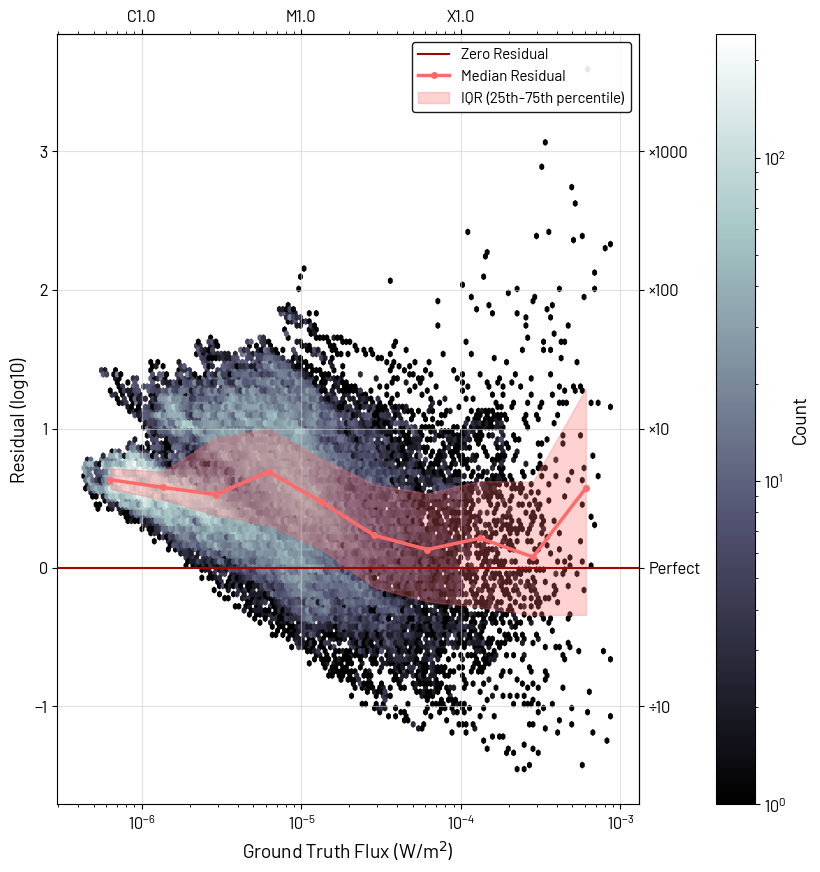

In [56]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Prepare features (X) and target (y)
feature_cols = [f'sum_flux_{w}' for w in ['94', '131', '171', '193', '211', '304', '335']]
X_train = train[feature_cols]
y_train = train['sxr_flux_normalized']

X_val = val[feature_cols]
y_val = val['sxr_flux_normalized']

# Define flare class boundaries (in unnormalized W/m^2)
def get_flare_class(sxr_flux):
    """
    Assign flare class based on SXR flux
    Returns: 'A', 'B', 'C', 'M', or 'X'
    """
    flux = np.abs(sxr_flux)
    # if flux < 1e-7:
    #     return 'A'
    if flux < 1e-6:
        return 'B'
    elif flux < 1e-5:
        return 'C'
    elif flux < 1e-4:
        return 'M'
    else:
        return 'X'

def compute_sample_weights(sxr_flux, weight_scheme='balanced'):
    """
    Compute sample weights based on flare class

    Parameters:
    -----------
    sxr_flux : array-like
        SXR flux values (unnormalized)
    weight_scheme : str
        'balanced' - inversely proportional to class frequency
        'custom' - manually defined weights favoring higher classes
        'sqrt_balanced' - square root of inverse frequency (less extreme)

    Returns:
    --------
    weights : array
        Sample weights for each instance
    """
    # Assign flare classes
    classes = np.array([get_flare_class(f) for f in sxr_flux])

    if weight_scheme == 'balanced':
        # Compute class frequencies
        unique_classes, counts = np.unique(classes, return_counts=True)
        class_weights = {cls: len(classes) / (len(unique_classes) * count)
                        for cls, count in zip(unique_classes, counts)}

    elif weight_scheme == 'sqrt_balanced':
        # Less extreme version of balanced
        unique_classes, counts = np.unique(classes, return_counts=True)
        class_weights = {cls: np.sqrt(len(classes) / (len(unique_classes) * count))
                        for cls, count in zip(unique_classes, counts)}

    elif weight_scheme == 'custom':
        # Custom weights: prioritize M and X class flares
        class_weights = {
            'A': 6.643528005464481,
            'B': 6.643528005464481,
            'C': 1.626986450317832,
            'M': 4.724573441010383,
            'X': 43.13137472283814
        }

    elif weight_scheme == 'none':
        class_weights = {
            'A': 1.0,
            'B': 1.0,
            'C': 1.0,
            'M': 1.0,
            'X': 1.0
        }

    else:
        raise ValueError(f"Unknown weight_scheme: {weight_scheme}")

    # Map weights to samples
    weights = np.array([class_weights[cls] for cls in classes])

    # Print weight statistics
    print(f"\nWeight scheme: {weight_scheme}")
    print("Class distribution and weights:")
    for cls in ['A', 'B', 'C', 'M', 'X']:
        mask = classes == cls
        if np.any(mask):
            print(f"  {cls}: {np.sum(mask):6d} samples, weight={class_weights[cls]:.4f}")

    return weights

# Compute sample weights for training set
# Try different schemes: 'balanced', 'sqrt_balanced', 'custom'
train_weights = compute_sample_weights(train['sxr_flux'], weight_scheme='custom')

# Define parameter grid for alpha
param_grid = {'alpha': np.logspace(-9, 10, 50)}

# Optimization on Validation Set with weighted training
best_alpha = None
best_mse_log = float('inf')
results = []

print("\nOptimizing alpha parameter...")
for i, alpha in enumerate(param_grid['alpha']):
    if i % 10 == 0:
        print(f"Testing alpha {i+1}/{len(param_grid['alpha'])}: {alpha:.2e}")

    lasso = Lasso(alpha=alpha, random_state=42, max_iter=100000)
    # Fit with sample weights
    lasso.fit(X_train, y_train, sample_weight=train_weights)
    y_pred_val = lasso.predict(X_val)

    # Calculate MSE on LOG scale for optimization
    y_pred_val_unnorm = unnormalize_sxr(y_pred_val, sxr_norms)
    y_val_unnorm = np.maximum(val['sxr_flux'], 1e-12)

    # Clip predictions to avoid log(0) or log(negative)
    y_pred_val_unnorm = np.maximum(y_pred_val_unnorm, 1e-12)

    y_pred_val_log = np.log10(y_pred_val_unnorm)
    y_val_log = np.log10(y_val_unnorm)

    mse_log = mean_squared_error(y_val_log, y_pred_val_log)
    results.append((alpha, mse_log))

    if mse_log < best_mse_log:
        best_mse_log = mse_log
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha}")
print(f"Best Validation MSE (log scale): {best_mse_log}")

# Train final model with best alpha on train set
lasso_best = Lasso(alpha=best_alpha, random_state=42, max_iter=100000)
lasso_best.fit(X_train, y_train, sample_weight=train_weights)

# Evaluation on Validation set with best model
y_pred_val = lasso_best.predict(X_val)

# Un-normalize data for analysis
y_val_unnorm = np.maximum(val['sxr_flux'], 1e-8)
y_pred_val_unnorm = np.maximum(unnormalize_sxr(y_pred_val, sxr_norms), 1e-8)

# Calculate metrics in log scale
y_val_log = np.log10(y_val_unnorm)
y_pred_val_log = np.log10(y_pred_val_unnorm)

mse_log = mean_squared_error(y_val_log, y_pred_val_log)
r2_log = r2_score(y_val_log, y_pred_val_log)

print(f"\n--- Validation Results ---")
print(f"Best Alpha: {best_alpha}")
print(f"Mean Squared Error (log scale) on Val: {mse_log}")
print(f"R-squared (log scale) on Val: {r2_log}")
print("\nCoefficients:")
for col, coef in zip(feature_cols, lasso_best.coef_):
    print(f"  {col}: {coef}")

# Calculate per-class performance on validation set
print("\n--- Per-Class Performance (Validation) ---")
val_classes = np.array([get_flare_class(f) for f in val['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = val_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_val_log[mask], y_pred_val_log[mask])
        cls_mae = mean_absolute_error(y_val_log[mask], y_pred_val_log[mask])
        cls_r2 = r2_score(y_val_log[mask], y_pred_val_log[mask])
        print(f"  Class {cls}: MSE={cls_mse:.4f}, MAE={cls_mae:.4f}, R²={cls_r2:.4f}, n={np.sum(mask)}")

# ===== TEST SET EVALUATION =====
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Prepare test data
X_test = test[feature_cols]
y_test = test['sxr_flux_normalized']

# Make predictions on test set
y_pred_test = lasso_best.predict(X_test)

# Un-normalize data for analysis
y_test_unnorm = np.maximum(test['sxr_flux'], 1e-8)
y_pred_test_unnorm = np.maximum(unnormalize_sxr(y_pred_test, sxr_norms), 1e-8)

# Calculate metrics in log scale
y_test_log = np.log10(y_test_unnorm)
y_pred_test_log = np.log10(y_pred_test_unnorm)

mse_test_log = mean_squared_error(y_test_log, y_pred_test_log)
rmse_test_log = np.sqrt(mse_test_log)
mae_test_log = mean_absolute_error(y_test_log, y_pred_test_log)
r2_test_log = r2_score(y_test_log, y_pred_test_log)

print(f"\n--- Overall Test Results ---")
print(f"Mean Squared Error (log scale): {mse_test_log:.6f}")
print(f"Root Mean Squared Error (log scale): {rmse_test_log:.6f}")
print(f"Mean Absolute Error (log scale): {mae_test_log:.6f}")
print(f"R-squared (log scale): {r2_test_log:.6f}")

# Calculate per-class performance on test set
print("\n--- Per-Class Performance (Test) ---")
test_classes = np.array([get_flare_class(f) for f in test['sxr_flux']])
for cls in ['A', 'B', 'C', 'M', 'X']:
    mask = test_classes == cls
    if np.any(mask):
        cls_mse = mean_squared_error(y_test_log[mask], y_pred_test_log[mask])
        cls_mae = mean_absolute_error(y_test_log[mask], y_pred_test_log[mask])
        cls_r2 = r2_score(y_test_log[mask], y_pred_test_log[mask])
        print(f"  Class {cls}: MSE={cls_mse:.4f}, MAE={cls_mae:.4f}, R²={cls_r2:.4f}, n={np.sum(mask)}")

# Compare validation vs test performance
print("\n--- Validation vs Test Comparison ---")
print(f"{'Metric':<25} {'Validation':<15} {'Test':<15} {'Difference':<15}")
print("-" * 70)
print(f"{'MSE (log scale)':<25} {mse_log:<15.6f} {mse_test_log:<15.6f} {mse_test_log - mse_log:<15.6f}")
print(f"{'R² (log scale)':<25} {r2_log:<15.6f} {r2_test_log:<15.6f} {r2_test_log - r2_log:<15.6f}")

# ===== VISUALIZATION =====
print("\n" + "="*60)
print("GENERATING PLOTS")
print("="*60)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import matplotlib.font_manager as fm
from matplotlib import rcParams

def setup_barlow_font():
    """Setup Barlow font for matplotlib plots"""
    try:
        # Try to find Barlow font with more specific search
        barlow_fonts = []
        for font in fm.fontManager.ttflist:
            if 'barlow' in font.name.lower() or 'barlow' in font.fname.lower():
                barlow_fonts.append(font.name)

        if barlow_fonts:
            rcParams['font.family'] = 'Barlow'
            print(f"Using Barlow font: {barlow_fonts[0]}")
        else:
            # Try alternative approach - directly specify font file
            barlow_path = '/usr/share/fonts/truetype/barlow/Barlow-Regular.ttf'
            barlow_path2 = '/Users/griffingoodwin/Library/Fonts/Barlow-Regular.otf'
            if os.path.exists(barlow_path):
                # Add the font file directly to matplotlib
                fm.fontManager.addfont(barlow_path)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path}")
            elif os.path.exists(barlow_path2):
                fm.fontManager.addfont(barlow_path2)
                rcParams['font.family'] = 'Barlow'
                print(f"Using Barlow font from: {barlow_path2}")
            else:
                # Fallback to sans-serif
                rcParams['font.family'] = 'sans-serif'
                print("Barlow font not found, using default sans-serif")
    except Exception as e:
        print(f"Font setup error: {e}, using default font")

def plot_regression_with_residuals(y_true, y_pred, title=""):
    """
    Generate regression comparison plot with residuals subplot.

    Creates a comprehensive visualization showing:
    - Top panel: 2D histogram of predicted vs. actual values with MAE contours
    - Bottom panel: Residuals (predicted - actual) in log space showing systematic bias
    - Perfect prediction line (1:1 relationship)
    - Flare class boundaries (A, B, C, M, X)
    - Logarithmic scaling for both axes
    - Professional styling with Barlow font and custom color scheme
    """
    setup_barlow_font()

    flare_classes = {
        'A1.0': (1e-8, 1e-7),
        'B1.0': (1e-7, 1e-6),
        'C1.0': (1e-6, 1e-5),
        'M1.0': (1e-5, 1e-4),
        'X1.0': (1e-4, 1e-3),
        'X10.0': (1e-3, 1e-2),
        'X100.0': (1e-2, 1e-1),
        'X1000.0': (1e-1, 1)
    }

    theme = 'white'
    axis_facecolor = '#FFFFFF' if theme == 'white' else '#FFFFFF'
    text_color = 'black' if theme == 'white' else '#FFFFFF'
    legend_facecolor = '#FFFFFF' if theme == 'white' else '#1E1E2F'
    grid_color = '#CCCCCC' if theme == 'white' else '#3A3A5A'
    minor_grid_color = '#E6E6E6' if theme == 'white' else '#1F1F35'
    legend_edge_color = 'black' if theme == 'white' else '#3A3A5A'
    colorbar_facecolor = axis_facecolor
    figure_facecolor = '#FFFFFF' if theme == 'white' else '#000000'

    def add_flare_class_axes(ax, min_val, max_val, tick_color):
        """
        Add flare class labels using true secondary axes that are
        mathematically tied to the parent axis.
        """

        # Identity transform (log space already handled by parent)
        def identity(x):
            return x

        # Create secondary axes
        ax_top = ax.secondary_xaxis('top', functions=(identity, identity))

        # Collect tick positions + labels
        flare_positions = []
        flare_labels = []

        for class_name, (min_flux, max_flux) in flare_classes.items():
            if min_val <= min_flux <= max_val:
                flare_positions.append(min_flux)
                flare_labels.append(class_name)

        # Apply ticks
        ax_top.set_xticks(flare_positions)
        ax_top.set_xticklabels(
            flare_labels,
            fontsize=12,
            color=tick_color,
            fontfamily='Barlow'
        )

        # Styling
        # ax_top.tick_params(colors=tick_color, length=6, width=1)
        # ax_right.tick_params(colors=tick_color, length=6, width=1)

        # Remove grids + backgrounds (important)
        ax_top.grid(False)



    def add_residual_class_axes(ax, tick_color):
        """
        Add flare class labels using true secondary axes that are
        mathematically tied to the parent axis.
        """

        # Identity transform (log space already handled by parent)
        def identity(x):
            return x

        # Create secondary axes
        ax_right = ax.secondary_yaxis('right', functions=(identity, identity))

        # Collect tick positions + labels
        residual_positions = [-4,-3,-2,-1,0,1,2,3,4]
        residual_labels = ["÷10000","÷1000","÷100","÷10","Perfect","×10","×100","×1000","×10000"]


        # Apply ticks
        ax_right.set_yticks(residual_positions)
        ax_right.set_yticklabels(
            residual_labels,
            fontsize=12,
            color=tick_color,
            fontfamily='Barlow'
        )


    # Create figure with 2 subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

    fig.patch.set_facecolor(figure_facecolor)
    fig.patch.set_alpha(1.0)



    # ===== BOTTOM PANEL: RESIDUALS =====
    # Calculate residuals in log space
    residuals = np.log10(y_pred) - np.log10(y_true)
    # Create 2D histogram for residuals
    h1 = ax1.hexbin(y_true, residuals, gridsize=150,
                    cmap="bone", alpha=1, xscale="log", bins="log")

    # Add zero line (perfect prediction)
    ax1.axhline(y=0, color='#A00503', linestyle='-', linewidth=1.5, label='Zero Residual', zorder=10)

    # Calculate and plot binned median residuals to show systematic bias
    min_val = min(y_true)
    max_val = max(y_true)
    n_bins = 10
    bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), n_bins + 1)
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])  # Geometric mean
    median_residuals = []
    q25_residuals = []
    q75_residuals = []

    for i in range(n_bins):
        mask = (y_true >= bin_edges[i]) & (y_true < bin_edges[i+1])
        if np.sum(mask) > 5:  # Only compute if enough samples
            median_residuals.append(np.median(residuals[mask]))
            q25_residuals.append(np.percentile(residuals[mask], 25))
            q75_residuals.append(np.percentile(residuals[mask], 75))
        else:
            median_residuals.append(np.nan)
            q25_residuals.append(np.nan)
            q75_residuals.append(np.nan)

    ax1.plot(bin_centers, median_residuals, color='#FF6B6B', linewidth=2.5,
             label='Median Residual', zorder=11, marker='o', markersize=4)
    ax1.fill_between(bin_centers, q25_residuals, q75_residuals,
                     color='#FF6B6B', alpha=0.3, label='IQR (25th-75th percentile)', zorder=9)

    # Styling
    ax1.set_facecolor(axis_facecolor)
    ax1.set_xlabel(r'Ground Truth Flux (W/m$^{2}$)', fontsize=14, color=text_color, fontfamily='Barlow')
    ax1.set_ylabel('Residual (log10)', fontsize=14, color=text_color, fontfamily='Barlow')
    #ax2.set_xscale('log')
    ax1.tick_params(labelsize=12, colors=text_color)
    ax1.grid(True, alpha=0.6, color=grid_color)

    # Grid styling
    # ax2.grid(True, which='minor', alpha=0.15, linewidth=0.25, linestyle='--', color=minor_grid_color)
    # ax2.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    # ax2.tick_params(which='minor', colors=text_color)

    # Legend
    legend2 = ax1.legend(loc='upper right', prop={'family': 'Barlow', 'size': 11})
    legend2.get_frame().set_facecolor(legend_facecolor)
    legend2.get_frame().set_edgecolor(legend_edge_color)
    legend2.get_frame().set_alpha(0.9)
    for text in legend2.get_texts():
        text.set_color(text_color)
        text.set_fontfamily('Barlow')

    # Set tick labels to Barlow font
    for label in ax1.get_xticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)
    for label in ax1.get_yticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)

    # # Colorbar styling
    cbar = fig.colorbar(h1, ax=[ax1], orientation='vertical', pad=.1)
    cbar.ax.yaxis.set_tick_params(labelsize=12, colors=text_color)
    cbar.set_label("Count", fontsize=14, color=text_color, fontfamily='Barlow')
    cbar.ax.tick_params(colors=text_color)
    cbar.ax.yaxis.set_tick_params(colors=text_color)
    cbar.ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs='auto', numticks=100))
    cbar.ax.tick_params(which='minor', colors=text_color)
    cbar.ax.set_facecolor(colorbar_facecolor)
    cbar.ax.patch.set_alpha(1.0)

    # Set colorbar tick labels to Barlow font
    for label in cbar.ax.get_yticklabels():
        label.set_fontfamily('Barlow')
        label.set_color(text_color)

    # Set spines
    for spine in ax1.spines.values():
        spine.set_color(text_color)
        spine.set_zorder(10)


    add_flare_class_axes(ax1, min_val, max_val, text_color)
    add_residual_class_axes(ax1,text_color)
    #plt.close()
    return fig, residuals


# # Plot validation results
# print("\nGenerating validation set plot...")
# plot_regression_with_residuals(y_val_unnorm, y_pred_val_unnorm)

# Plot test results
print("Generating test set plot...")
_, residuals = plot_regression_with_residuals(y_test_unnorm, y_pred_test_unnorm)

In [9]:
test

,sum_flux_94,sum_flux_131,sum_flux_171,sum_flux_193,sum_flux_211,sum_flux_304,sum_flux_335,filename,timestamp,sxr_flux,sxr_flux_normalized
0,-196843.72,-196055.12,-106819.914,-68804.000,-92321.470,-122797.240,-147060.34,2023-08-01T00:00:00.npy,2023-08-01 00:00:00,0.000003,0.025543
1,-196831.34,-196110.30,-108905.910,-68786.055,-92310.360,-122770.040,-147090.06,2023-08-01T00:01:00.npy,2023-08-01 00:01:00,0.000003,0.024767
2,-196688.38,-196193.31,-108975.700,-68785.766,-92311.945,-122728.190,-147227.08,2023-08-01T00:03:00.npy,2023-08-01 00:03:00,0.000003,0.019328
3,-196823.53,-196036.02,-109010.380,-68791.820,-92297.500,-122846.625,-147089.60,2023-08-01T00:04:00.npy,2023-08-01 00:04:00,0.000003,0.013948
4,-196832.25,-196109.80,-108999.086,-68813.810,-92325.640,-122816.240,-147055.19,2023-08-01T00:05:00.npy,2023-08-01 00:05:00,0.000003,0.010229
...,...,...,...,...,...,...,...,...,...,...,...
100192,-194550.94,-201906.84,-116466.310,-87035.090,-111005.910,-134399.690,-151818.72,2025-09-26T20:17:00.npy,2025-09-26 20:17:00,0.000004,0.094361
100193,-194584.00,-201919.28,-116529.310,-87337.625,-111037.630,-134419.750,-152003.50,2025-09-26T20:18:00.npy,2025-09-26 20:18:00,0.000004,0.064023
100194,-194670.88,-201917.78,-116512.400,-87066.450,-111055.766,-134361.980,-151734.81,2025-09-26T20:19:00.npy,2025-09-26 20:19:00,0.000004,0.039572
100195,-194634.40,-201907.12,-116535.984,-87106.110,-111052.000,-134395.970,-151819.88,2025-09-26T20:20:00.npy,2025-09-26 20:20:00,0.000003,0.013911


In [10]:

residuals['index'] = residuals.index
test['index'] = test.index

In [147]:
residuals.index

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
        100188,  100189,  100190,  100191,  100192,  100193,  100194,  100195,
        100196, 'index'],
      dtype='object', length=100198)

In [11]:
merge = pd.merge(test, residuals, left_index=True, right_index=True)

In [28]:
merge[merge['sxr_flux_y']<-1.2]

,sum_flux_94,sum_flux_131,sum_flux_171,sum_flux_193,sum_flux_211,sum_flux_304,sum_flux_335,filename,timestamp,sxr_flux_x,sxr_flux_normalized,index,sxr_flux_y
39615,-202968.64,-201980.94,-116150.305,-84078.470,-115889.450,-128640.580,-168592.78,2023-12-14T16:59:00.npy,2023-12-14 16:59:00,0.000179,2.572091,39615,-1.220994
39621,-174198.78,-197379.06,-116494.984,-83736.890,17591.328,-128274.960,-167143.27,2023-12-14T17:05:00.npy,2023-12-14 17:05:00,0.000248,2.781290,39621,-4.393771
40016,-200807.22,-199219.16,-110000.840,-78052.760,-110869.875,-128376.086,-165781.19,2023-12-31T21:41:00.npy,2023-12-31 21:41:00,0.000138,2.405863,40016,-1.242932
42444,-194852.62,-193698.48,-97569.484,-62635.970,-97077.984,-124176.470,-152978.72,2024-02-09T13:05:00.npy,2024-02-09 13:05:00,0.000148,2.449694,42444,-1.300269
42445,-194828.42,-192051.39,-97731.910,-69359.450,-97177.140,-124124.530,-153106.69,2024-02-09T13:06:00.npy,2024-02-09 13:06:00,0.000194,2.623737,42445,-1.335233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53568,-190047.81,-190429.53,-104003.560,-72365.125,-89281.390,-123220.630,-138639.19,2024-05-14T16:50:00.npy,2024-05-14 16:50:00,0.000837,3.566120,53568,-1.243164
54805,-199454.34,-197693.73,-109791.920,-76528.180,-106483.440,-127832.160,-161060.05,2024-05-27T07:02:00.npy,2024-05-27 07:02:00,0.000161,2.505505,54805,-1.217627
54806,-199246.48,-198148.81,-109801.950,-74365.470,-106525.330,-127743.920,-161089.02,2024-05-27T07:03:00.npy,2024-05-27 07:03:00,0.000198,2.638360,54806,-1.307153
54808,-198408.83,-196862.30,-110133.110,-74402.780,-106817.790,-128221.090,-161326.66,2024-05-27T07:05:00.npy,2024-05-27 07:05:00,0.000250,2.788726,54808,-1.292102


In [17]:
# Analysis of values where sxr_flux_y < -1.5 (log residuals < -1.5)
# This means the model underpredicts the flux by more than a factor of ~31 (10^1.5)
underpredicted = merge[merge['sxr_flux_y'] < -1.5]
print(f"Number of underpredicted samples (residual < -1.5): {len(underpredicted)}")
underpredicted[['timestamp', 'sxr_flux_x', 'sxr_flux_y']].head(20)

Number of underpredicted samples (residual < -1.5): 105


,timestamp,sxr_flux_x,sxr_flux_y
39621,2023-12-14 17:05:00,0.000248,-4.393771
48518,2024-04-30 15:00:00,0.000003,-1.699272
48519,2024-04-30 15:01:00,0.000004,-1.769629
48520,2024-04-30 15:02:00,0.000005,-1.838435
48521,2024-04-30 15:03:00,0.000006,-1.919489
48522,2024-04-30 15:04:00,0.000007,-1.961578
48523,2024-04-30 15:05:00,0.000008,-2.008894
48524,2024-04-30 15:06:00,0.000009,-2.054478
48525,2024-04-30 15:07:00,0.000010,-2.091459
48526,2024-04-30 15:08:00,0.000011,-2.13606


In [ ]:
import matplotlib.pyplot as plt

# Compare AIA fluxes of underpredicted samples vs others
feature_cols = [f'sum_flux_{w}' for w in ['94', '131', '171', '193', '211', '304', '335']]

output_dir = "analysis_figures_underpredicted"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(15, 10))
for i, col in enumerate(feature_cols):
    plt.subplot(3, 3, i+1)
    plt.hist(merge[col], bins=50, alpha=0.5, label='All', density=True)
    plt.hist(underpredicted[col], bins=50, alpha=0.5, label='Residual < -1.5', density=True)
    plt.title(f'Log10 {col}')
    plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_distributions.png"))
plt.show()

In [ ]:
# Look at the temporal distribution of these samples
underpredicted['timestamp'] = pd.to_datetime(underpredicted['timestamp'])
plt.figure(figsize=(12, 4))
plt.hist(underpredicted['timestamp'], bins=50)
plt.title('Temporal Distribution of Underpredicted Samples')
plt.xlabel('Date')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, "temporal_distribution.png"))
plt.show()

In [31]:
# Visualizing a few AIA images for these samples
# Note: Paths might need adjustment based on where data is stored
aia_test_path = "/Volumes/T9/FOXES_Data/AIA/test/"

def plot_aia_sample(sample_row, idx, save_dir=None):
    # Try multiple common timestamp formats if the default one fails
    timestamp_formats = ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%d %H:%M:%S', '%Y-%m-%dT%H_%M_%S']
    file_path = None
    
    for fmt in timestamp_formats:
        ts_str = sample_row['timestamp'].strftime(fmt)
        possible_path = os.path.join(aia_test_path, f"{ts_str}.npy")
        if os.path.exists(possible_path):
            file_path = possible_path
            break
            
    if file_path and os.path.exists(file_path):
        try:
            aia_data = np.load(file_path)
            fig, axes = plt.subplots(1, 7, figsize=(20, 3))
            channels = ['94', '131', '171', '193', '211', '304', '335']
            for i in range(7):
                axes[i].imshow(aia_data[i], cmap='hot')
                axes[i].set_title(f'Ch {channels[i]}')
                axes[i].axis('off')
            title = f"Sample at {sample_row['timestamp']} | True Flux: {sample_row['sxr_flux_x']:.2e} | Residual: {sample_row['sxr_flux_y']:.2f}"
            plt.suptitle(title)
            
            if save_dir:
                ts_safe = sample_row['timestamp'].strftime('%Y%m%d_%H%M%S')
                save_path = os.path.join(save_dir, f"aia_sample_{ts_safe}.png")
                plt.savefig(save_path)
                
            plt.close()
            #plt.show()
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    else:
        # List a few files in the directory to see the format
        print(f"File not found for {sample_row['timestamp']}. Checked path: {os.path.join(aia_test_path, sample_row['timestamp'].strftime('%Y-%m-%dT%H:%M:%S') + '.npy')}")
        if idx == 0: # Only do this once
             files = os.listdir(aia_test_path)[:5] if os.path.exists(aia_test_path) else []
             print(f"Sample files in {aia_test_path}: {files}")

# Plot and save first 20 samples
output_dir = "/Volumes/T9/Outliers"
for i in range(len(underpredicted)):
    plot_aia_sample(underpredicted.iloc[i], i, save_dir=output_dir)

In [37]:
aia = np.load("/Volumes/T9/FOXES_Data/AIA/test/2024-04-30T15:00:00.npy")

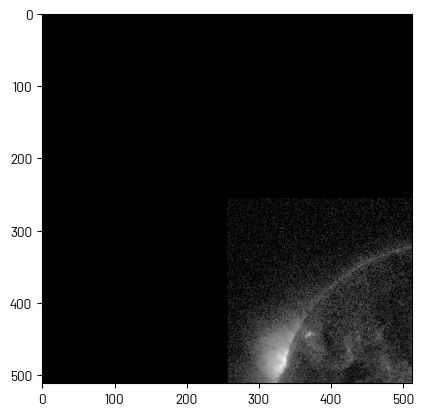

In [38]:
plt.imshow(aia[6],cmap='gray')

In [41]:
aia[6].min()


AttributeError: 'numpy.ndarray' object has no attribute 'median'

In [42]:
np.median(aia[6])

np.float32(-1.0)

In [45]:
test_filtered = test[~test['filename'].isin(underpredicted['filename'])]
